In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# from keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import array_to_img
# from sklearn.model_selection import train_test_split
# from PIL import Image
# import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot
from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

# from tqdm import tqdm, tqdm_notebook
# from colorama import Fore
# import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
# import time
# from sklearn.decomposition import PCA
# from sklearn.svm import LinearSVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# import lightgbm as lgb
# import xgboost as xgb
# !pip install livelossplot
# import livelossplot
# from livelossplot import PlotLossesKeras
import warnings
warnings.filterwarnings('ignore')
print("All modules have been imported")


All modules have been imported


In [3]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
import pandas as pd
info = pd.read_csv("1000_Binary Dataframe")
info = info.drop('Unnamed: 0', axis=1)
Binary_90 = np.load('1000_Binary_images_data_90.npz')
X_90 = Binary_90['a']
Binary_128 = np.load('1000_Binary_images_data_128.npz')
X_128 = Binary_128['a']
Binary_264 = np.load('1000_Binary_images_data_264.npz')
X_264 = Binary_264['a']
y = info['level'].values

In [6]:
# Reshape images
X_90 = X_90.reshape(1000, 90, 90, 3)
X_128 = X_128.reshape(1000, 128, 128, 3)
X_264 = X_264.reshape(1000, 264, 264, 3)

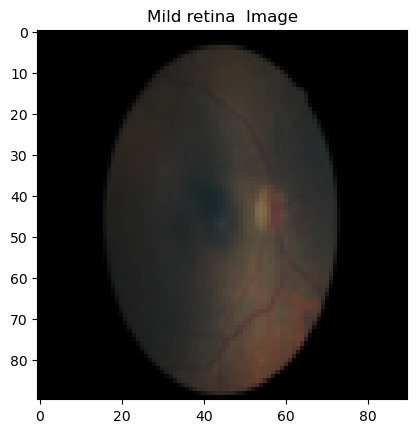

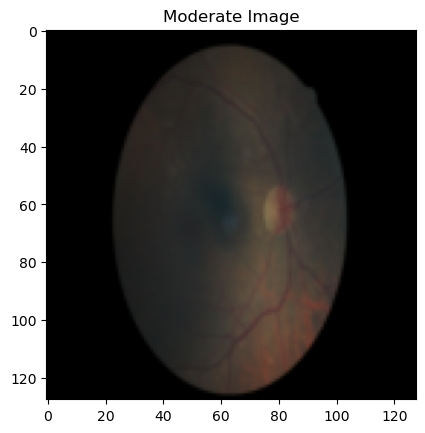

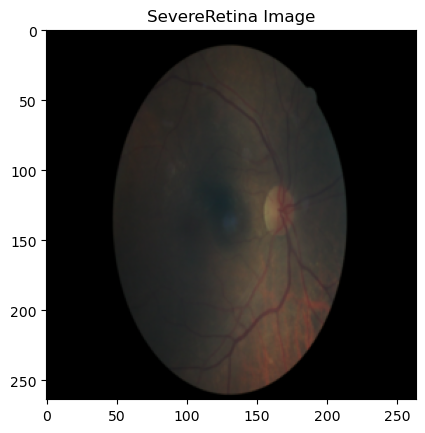

In [9]:
# Display images
plt.title("Mild retina  Image")
plt.imshow(X_90[1])
plt.show()

plt.title("Moderate Image")
plt.imshow(X_128[1])
plt.show()

plt.title("SevereRetina Image")
plt.imshow(X_264[1])
plt.show()

In [11]:
# Prepare data for training
X = np.array(X_264)
Y = np.array(y)
Y = to_categorical(Y, 5)
x_train, x_test1, y_train, y_test1 = train_test_split(X, Y, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test1, y_test1, test_size=0.5, random_state=42)
print(len(x_train), len(x_val), len(x_test))

600 200 200


In [12]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
# Callbacks
c3 = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.001
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [17]:
# Model with transfer learning (VGG16)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(264, 264, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

In [19]:
# Compile the model with the Adam optimizer, categorical cross-entropy loss, and metrics for accuracy and AUC
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])

# Training the model with fewer epochs (e.g., 20), smaller batch size (e.g., 8), and callbacks for early stopping and learning rate reduction
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=32),
    validation_data=val_datagen.flow(x_val, y_val),
    epochs=30,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001), 
               EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Evaluate the model on the test data
evaluation = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {evaluation[1]*100:.2f}%')

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 218s 10s/step - AUC: 0.8021 - accuracy: 0.5410 - loss: 2.3405 - val_AUC: 0.8175 - val_accuracy: 0.2700 - val_loss: 0.8758 - learning_rate: 0.0010
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 187s 10s/step - AUC: 0.8596 - accuracy: 0.5922 - loss: 1.7343 - val_AUC: 0.9325 - val_accuracy: 0.7300 - val_loss: 0.6424 - learning_rate: 0.0010
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2217s 123s/step - AUC: 0.9152 - accuracy: 0.6373 - loss: 0.8830 - val_AUC: 0.9325 - val_accuracy: 0.7300 - val_loss: 0.6306 - learning_rate: 0.0010
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 178s 9s/step - AUC: 0.9227 - accuracy: 0.6707 - loss: 0.7019 - val_AUC: 0.9325 - val_accuracy: 0.7300 - val_loss: 0.6149 - learning_rate: 0.0010
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 128s 7s/step - AUC: 0.9249 - accuracy: 0.6727 - loss: 0.6461 - val_AUC: 0.9325 - val_accuracy: 0.7300 - val_loss: 0.6238 - learning_rate: 0.0010
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 132s 7s/step - AUC: 0.9174 - accuracy: 0.6

In [21]:
y_test=np.argmax(y_test, axis=1)
pred=np.argmax(model.predict(x_test),axis=-1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step


In [23]:
print("Performance Report:")
y_pred6=np.argmax(model.predict(x_test),axis=-1)
Y_test=to_categorical(y_test,5)
y_pred_prb6=model.predict(x_test)
target=['0','1']
from sklearn import metrics
print('Accuracy score is :', metrics.accuracy_score(y_test, y_pred6))
print('Precision score is :', metrics.precision_score(y_test, y_pred6, average='weighted'))
print('Recall score is :',metrics.recall_score(y_test,y_pred6, average='weighted'))
print('F1 Score is :', metrics.f1_score(y_test, y_pred6,average='weighted'))
print('Cohen Kappa Score:', metrics.cohen_kappa_score(y_test, y_pred6))
print('\tClassification Report:\n', metrics.classification_report(y_test, y_pred6, target_names=target))


Performance Report:
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step
Accuracy score is : 0.785
Precision score is : 0.616225
Recall score is : 0.785
F1 Score is : 0.6904481792717087
Cohen Kappa Score: 0.0
	Classification Report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88       157
           1       0.00      0.00      0.00        43

    accuracy                           0.79       200
   macro avg       0.39      0.50      0.44       200
weighted avg       0.62      0.79      0.69       200



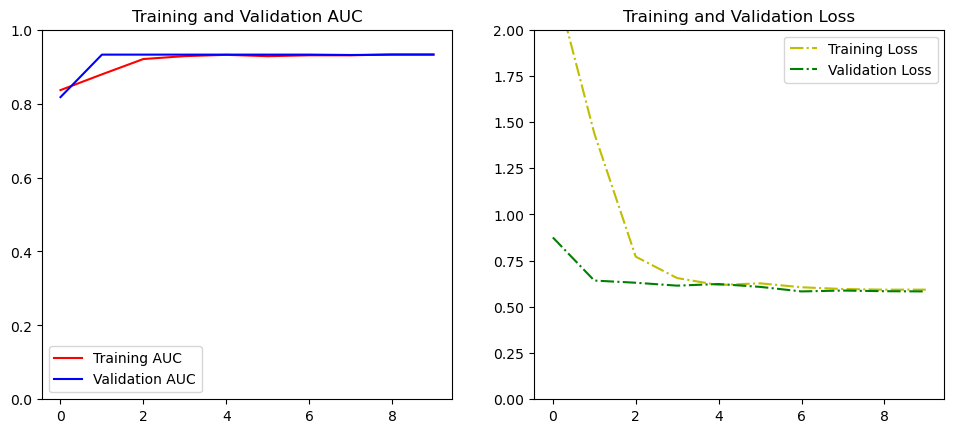

In [24]:
# Extracting the metrics using correct keys
auc = history.history['AUC']
val_auc = history.history['val_AUC']
loss = history.history['loss']
val_loss = history.history['val_loss']


# Plotting the metrics
epochs = range(len(auc))
plt.figure(figsize=(18, 4.8))

# Plotting Training and Validation AUC
plt.subplot(1, 3, 1)
plt.plot(epochs, auc, 'r', label='Training AUC')
plt.plot(epochs, val_auc, 'b', label='Validation AUC')
plt.ylim(0, 1)
plt.title('Training and Validation AUC')
plt.legend(loc=0)

# Plotting Training and Validation Loss
plt.subplot(1, 3, 2)
plt.plot(epochs, loss, 'y-.', label='Training Loss')
plt.plot(epochs, val_loss, 'g-.', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylim(0, 2)
plt.legend(loc=0)



plt.show()